# Texas COVID-19 Data analysis

---

## Data

This analysis attempts to fit the COVID case data 
from the Texas Department of State Health Services' website:

https://www.dshs.texas.gov/coronavirus/

*Date of data access:* 02-23-2021

The population estimates of each county were obtained from the 2019 Texas Dempgraphic Center population estimate by county:

https://demographics.texas.gov/data/tpepp/estimates/

*Date of data access:* 02-26-2021

The vaccine allocation data *(unused)* was obtained here:

https://www.dshs.texas.gov/coronavirus/immunize/vaccineallocations.aspx

*Date of data Access:* 02-26-2021


---
## Model

The model employed here is the SIR model (Susceptible-Infected-Recovered) model, as described in the following MAA article: 

https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model

The SIR model:

$\qquad\dfrac{ds}{dt} = -bs(t)i(t),$

$\qquad\dfrac{di}{dt} = b s(t) i(t) - k i(t),$

$\qquad\dfrac{dr}{dt} = k i(t)$

$ s(0) = 1,\qquad i(0) = i_0, \qquad r(0) = 0$

The parameters of the system are:

* $b$: average number of population members infected by an infected individual per unit time

* $k$: fraction of the infected group that can recover in a given day

Sometimes, $b$ can be parameterized as a "forcing" term $b(t)$, as the number of population members infected per carrier per unit time may change depending on external factors.

The ratio $b/k$ is sometimes referred to as the "basic reproduction number", or $\mathcal{R}_0$. It is a unitless quantity that estimates the average total number of members of the population that will be infected by a single carrier during the period that they are infectious.

---

## Extracting actionable insights from the model

Since we already have the time series data for $s(t)$, $i(t)$, and $r(t)$, we can do the following:

* Forecast future values of $s(t), i(t), r(t)$.

* Fit the data to the SIR ODE system to obtain a variadic b(t) and R_0(t), which measures the contagiousness of a single carrier of COVID at time $t$.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#======================================================================
# directory of data set:
DATA_DIR = './data/'

# data sets:
DATA = {
    
    # Excel datasets:
    'active_cases' : 'TexasCOVID-19ActiveCaseDatabyCounty.xlsx',
    'case_counts' : 'TexasCOVID-19CaseCountDatabyCounty.xlsx',
    'fatality_counts' : 'TexasCOVID-19FatalityCountDatabyCounty.xlsx',
    'legacy_active_cases' : 'TexasCOVID-19LegacyActiveCaseDatabyCounty.xlsx',
    'new_confirmed_cases' : 'TexasCOVID-19NewConfirmedCasesbyCounty.xlsx',
    'new_probable_cases' : 'TexasCOVID-19NewProbableCasesbyCounty.xlsx',
    'probable_cases' : 'TexasCOVID-19ProbableCasesbyCounty.xlsx',
    
    # CSV datasets:
    'total_population' : '2019_txpopest_county.csv'
}

# default county in TX:
DEFAULT_COUNTY = 'McLennan'

# date of first data point (hardcoded by dataset):
DATA_START_DATES = {
    'active_cases' :        np.datetime64('2020-12-11'),
    'case_counts' :         np.datetime64('2020-03-04'),
    'fatality_counts':      None, # not used here
    'legacy_active_cases' : np.datetime64('2020-04-07'),
    'new_confirmed_cases' : None, # not used here
    'new_probable_cases' :  None, # not used here
    'probable_cases' :      np.datetime64('2020-11-01'),
}

#=======================================================================

def load_active_cases(county=DEFAULT_COUNTY):
    # import couty of interest data
    new_coi_data = pd.read_excel(DATA_DIR + DATA['active_cases'], index_col=None, header=2) \
        .query(f'County == \'{county}\'')

    # import county of interest legacy data:
    leg_coi_data = pd.read_excel(DATA_DIR + DATA['legacy_active_cases'], index_col=None, header=2) \
        .query(f'County == \'{county}\'')

    # trim datasets:
    new_coi_y = new_coi_data.to_numpy()[0,2:]
    leg_coi_y = leg_coi_data.to_numpy()[0,2:]
    coi_y = np.concatenate((leg_coi_y, new_coi_y))

    # initialize date ranges:
    start_t = DATA_START_DATES['legacy_active_cases']
    end_t = start_t + np.timedelta64(len(coi_y), 'D')
    coi_t = np.arange(start_t, end_t, dtype='datetime64[D]')

    # return (dates, # of active cases)
    return (coi_t, coi_y)

def load_case_counts(county=DEFAULT_COUNTY):
    # import county of interest data:
    coi_data = pd.read_excel(DATA_DIR + DATA['case_counts'], index_col=None, header=2) \
        .query(f'`County Name` == \'{county}\'')
    coi_y = coi_data.to_numpy()[0,1:]
    
    # initialize data ranges:
    start_t = DATA_START_DATES['case_counts']
    end_t = start_t + np.timedelta64(len(coi_y), 'D')
    coi_t = np.arange(start_t, end_t, dtype='datetime64[D]')

    # return (dates, case counts)
    return (coi_t, coi_y)

def load_probable_cases(county=DEFAULT_COUNTY):
    # import county of interest data:
    coi_data = pd.read_excel(DATA_DIR + DATA['probable_cases'], 
                             index_col=None, header=2) \
        .query(f'`County` == \'{county}\'')
    coi_y = coi_data.to_numpy()[0,1:]
    
    # initialize data ranges:
    start_t = DATA_START_DATES['probable_cases']
    end_t = start_t + np.timedelta64(len(coi_y), 'D')
    coi_t = np.arange(start_t, end_t, dtype='datetime64[D]')
    
    # return (dates, probable cases)
    return (coi_t, coi_y)

def load_population(county=DEFAULT_COUNTY):
    # import county population data:
    pop_data = pd.read_csv(DATA_DIR + DATA['total_population']) \
        .query(f'`county` == \'{county}\'')
    
    # extract Jan 1 2020 population estimate
    return pop_data.jan1_2020_pop_est.to_numpy()[0]

## Data Visualizations:

This cell visualizes the number of active cases for the county of interest (COI) with respect to time. In the Datasets used here, some counties produced metrics of "probable" cases, which can be added to the recorded active cases as a more reliable estimate of the actual number of active cases. In this model, we will disregard these probable cases.

Below, we visualize the number of active cases and the number of active cases as a fraction of the population. This normalized value will serve as an estimate of $i(t)$.

/shared/colin/git/tx_covid_models/env/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# of days tracked:  392
Estimated total population:  255372


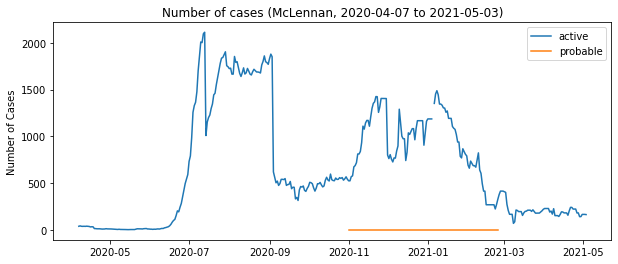

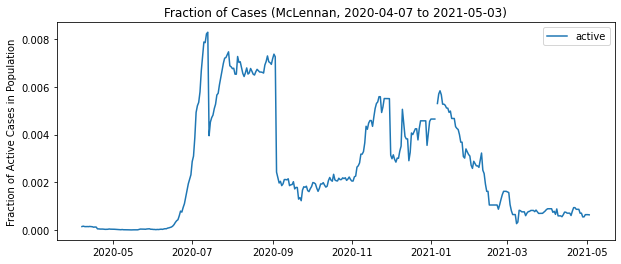

In [2]:
# load active + probable cases:
coi_t, coi_y = load_active_cases()
coi_pt, coi_py = load_probable_cases()

# normalize by population (Jan 1 2020)
pop_estimate = load_population()
coi_y_norm = coi_y / pop_estimate

# indicate $ of data points, population:
print('# of days tracked: ', len(coi_t))
print('Estimated total population: ', pop_estimate)

# plot active cases:
plt.figure(figsize=(10,4))
plt.ylabel('Number of Cases')
plt.title(f'Number of cases ({DEFAULT_COUNTY}, {coi_t[0]} to {coi_t[-1]})')
plt.plot(coi_t, coi_y, label='active')
plt.plot(coi_pt, coi_py, label='probable')
plt.legend()
plt.show()

# plot active cases (proportion of population):
plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Active Cases in Population')
plt.title(f'Fraction of Cases ({DEFAULT_COUNTY}, {coi_t[0]} to {coi_t[-1]})')
plt.plot(coi_t, coi_y_norm, label='active')
plt.legend()
plt.show()

---

This cell visualizes the total number of cases recorded for the COI. Dividing this by the total population of the COI, we obtain an estimate of $1 - s(t)$.

# of days tracked:  424


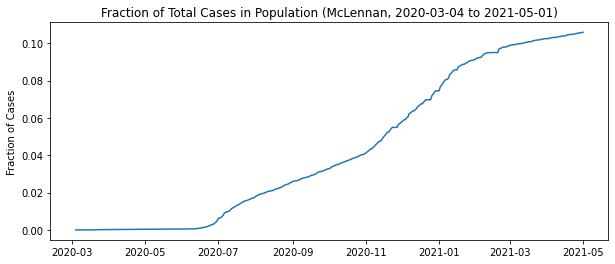

In [3]:
# load total cases:
coi_t, coi_y = load_case_counts()

# normalize by population (Jan 1 2020)
pop_estimate = load_population()
coi_y_norm = coi_y / pop_estimate

# indicate # of data points:
print('# of days tracked: ', len(coi_t))

# plot active cases:
plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Cases')
plt.title(f'Fraction of Total Cases in Population ({DEFAULT_COUNTY}, {coi_t[0]} to {coi_t[-1]})')
plt.plot(coi_t, coi_y_norm)
plt.show()




---

This cell combines the data from the previous cells to produce time series estimates of $s(t), i(t)$, and $r(t)$ for the intersection of the time intervals of the data used above.

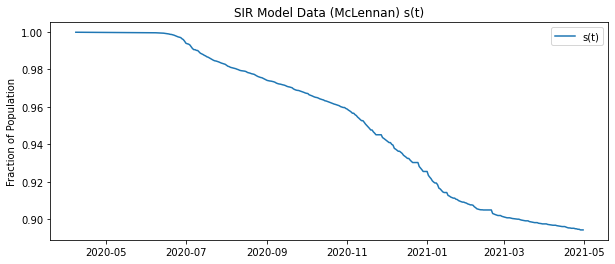

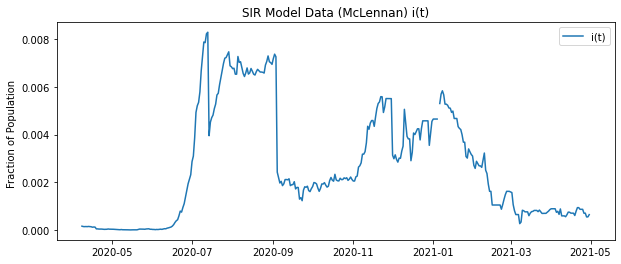

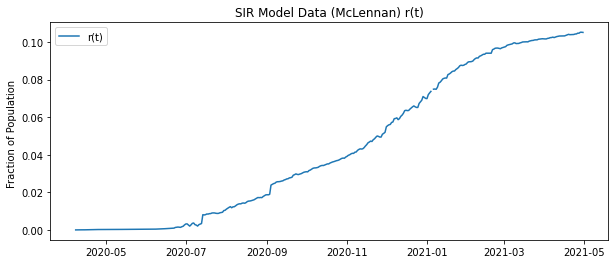

In [4]:
# generate SIR model estimate quantities:
coi_active_t, coi_active_y = load_active_cases()
coi_total_t, coi_total_y = load_case_counts()
pop_estimate = load_population()

S_t, S_y = coi_total_t, 1. - (coi_total_y/pop_estimate)
I_t, I_y = coi_active_t, coi_active_y / pop_estimate

# take the intersection of supported time intervals:
start_t = max(S_t[0], I_t[0])
end_t = min(S_t[-1], I_t[-1])
S_y = S_y[(start_t < S_t) & (S_t < end_t)]
S_t = S_t[(start_t < S_t) & (S_t < end_t)]
I_y = I_y[(start_t < I_t) & (I_t < end_t)]
I_t = I_t[(start_t < I_t) & (I_t < end_t)]

# estimate R:
R_t = S_t
R_y = (1.0 - S_y) - I_y


# plot SIR model curves
plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Population')
plt.title(f'SIR Model Data ({DEFAULT_COUNTY}) s(t)')
plt.plot(S_t, S_y, label='s(t)')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Population ')
plt.title(f'SIR Model Data ({DEFAULT_COUNTY}) i(t)')
plt.plot(I_t, I_y, label='i(t)')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Population ')
plt.title(f'SIR Model Data ({DEFAULT_COUNTY}) r(t)')
plt.plot(R_t, R_y, label='r(t)')
plt.legend()
plt.show()

## Data Forecasting:

This cell fits the County of Interest (COI) data to a standard SIR model with a fixed k and b value

optimal b value: 0.25774629399750715
optimal k value: 0.24223194228844108
Estimated R_0 value : 1.0640


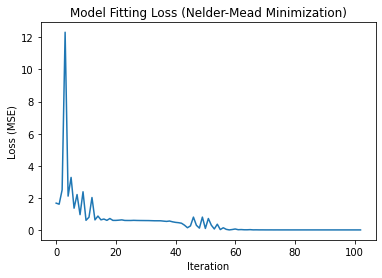

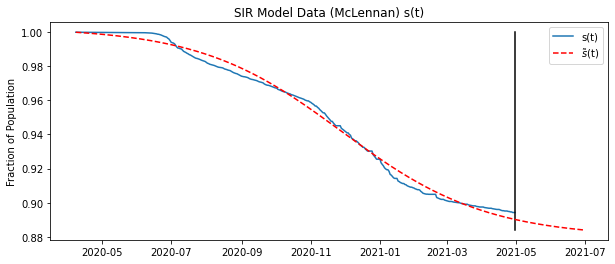

/shared/colin/git/tx_covid_models/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


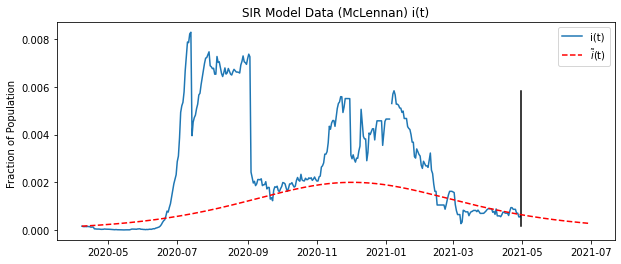

/shared/colin/git/tx_covid_models/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


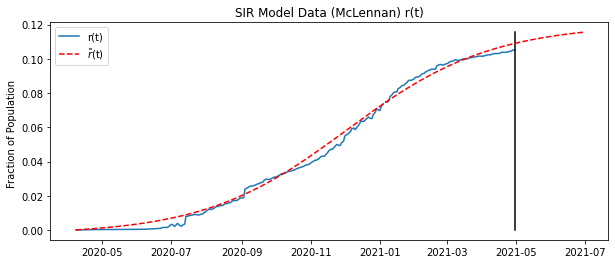

=========== Known Outcome (2021-04-30) ===========
Fraction of uninfected individuals: 0.8943
Fraction of infectious individuals: 0.0007
Fraction of recovered individuals: 0.1050

Actual uninfected individuals: 228388
Actual infectious individuals: 166
Actual recovered individuals: 26818

=========== Forecasted Outcome (2021-06-29) ===========
Fraction of uninfected individuals: 0.8842
Fraction of infectious individuals: 0.0003
Fraction of recovered individuals: 0.1156

Actual uninfected individuals: 225788
Actual infectious individuals: 73
Actual recovered individuals: 29511



In [5]:
# !! This requires the cell above to be run first

from scipy.optimize import minimize
from scipy.integrate import odeint

#======================================================================

# number of days to forecast ahead:
N_DAYS_FORECAST = 60

#======================================================================

# Right hand side of SIR ODE system where
#    y := (s(t), i(t), r(t)),
#    b, k are fixed constants
def SIR_RHS(y, t, b, k):
    ds_dt = -b*y[0]*y[1]
    di_dt = b*y[0]*y[1] - k*y[1]
    dr_dt = k*y[1]
    
    return np.array([ds_dt, di_dt, dr_dt])

def fit_constant_sir_model(s_data, i_data, r_data, 
                           b_guess=1.0, k_guess=1.0,  
                           n_iterations=1000,
                           loss_weights=np.array([1.,1.,1.])):
    
    # perfrom sanity check and set-up:
    assert(len(s_data) == len(i_data))
    assert(len(s_data) == len(r_data))
    eval_loss = []
    y_0 = np.array([s_data[0],i_data[0],r_data[0]])
    t_norm = np.arange(0, len(s_data))
    
    # loss function for model fit:
    def model_loss(params):
        
        # this integrates the system with 4-stage Runge Kutta (RK4):
        y_approx = odeint(SIR_RHS, y_0, t_norm, args=(params[0],params[1]))
        s_approx = y_approx[:,0]
        i_approx = y_approx[:,1]
        r_approx = y_approx[:,2]
        
        # use MSE loss (weighted by fraction of population)
        loss = np.nansum(loss_weights[0]*(s_approx - s_data)**2 + 
                      loss_weights[1]*(i_approx - i_data)**2 + 
                      loss_weights[2]*(r_approx - r_data)**2)
        
        # ensure b and k are > 0:
        if params[0] < 0:
            loss += 1000*np.abs(params[0])
        if params[1] < 0:
            loss += 1000*np.abs(params[1])
        
        eval_loss.append(loss)
        return loss
    
    # perform loss minimization & return result:
    param_guess = np.array([b_guess, k_guess])

    result = minimize(model_loss, param_guess, method='nelder-mead',
                      options={'maxiter' : n_iterations})
    
    # generate optimal data:
    opt_params = result.x
    
    return opt_params, eval_loss

# generate best fit:
opt_params, eval_loss = fit_constant_sir_model(S_y,I_y,R_y)
y_0 = np.array([S_y[0],I_y[0],R_y[0]])
t_norm = np.arange(0, len(S_y) + N_DAYS_FORECAST)
opt_data = odeint(SIR_RHS, y_0, t_norm, args=(opt_params[0],opt_params[1]))

S_y_fit = opt_data[:,0]
I_y_fit = opt_data[:,1]
R_y_fit = opt_data[:,2]
S_t_fit = I_t_fit = R_t_fit = np.arange(S_t[0], S_t[0]+np.timedelta64(len(S_y_fit), 'D'))

# print best fit:
print(f'optimal b value: {opt_params[0]}')
print(f'optimal k value: {opt_params[1]}')
print(f'Estimated R_0 value : {opt_params[0]/opt_params[1]:.4f}')

# plot fitting loss function:
plt.figure()
plt.title('Model Fitting Loss (Nelder-Mead Minimization)')
plt.plot(eval_loss)
#plt.ylim((np.nanmin(eval_loss), 2.0))
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.show()

# plot fitted SIR model curves
plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Population')
plt.title(f'SIR Model Data ({DEFAULT_COUNTY}) s(t)')
plt.plot(S_t, S_y, label='s(t)')
plt.plot([S_t[-1]]*2,[min(np.min(S_y),np.min(S_y_fit)),
                      max(np.max(S_y),np.max(S_y_fit))],'k')
plt.plot(S_t_fit, S_y_fit, 'r--', label=r'$\tilde{s}$(t)')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Population ')
plt.title(f'SIR Model Data ({DEFAULT_COUNTY}) i(t)')
plt.plot(I_t, I_y, label='i(t)')
plt.plot([I_t[-1]]*2,[min(np.min(I_y),np.min(I_y_fit)),
                      max(np.max(I_y),np.max(I_y_fit))],'k')
plt.plot(I_t_fit, I_y_fit, 'r--', label=r'$\tilde{i}$(t)')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Population ')
plt.title(f'SIR Model Data ({DEFAULT_COUNTY}) r(t)')
plt.plot(R_t, R_y, label='r(t)')
plt.plot([R_t[-1]]*2,[min(np.min(R_y),np.min(R_y_fit)),
                      max(np.max(R_y),np.max(R_y_fit))],'k')
plt.plot(R_t_fit, R_y_fit, 'r--', label=r'$\tilde{r}$(t)')

plt.legend()
plt.show()

# print outcome statistics:
print(f'=========== Known Outcome ({S_t[-1]}) ===========')
print(f'Fraction of uninfected individuals: {S_y[-1]:.4f}')
print(f'Fraction of infectious individuals: {I_y[-1]:.4f}')
print(f'Fraction of recovered individuals: {R_y[-1]:.4f}\n')
print(f'Actual uninfected individuals: {pop_estimate*S_y[-1]:.0f}')
print(f'Actual infectious individuals: {pop_estimate*I_y[-1]:.0f}')
print(f'Actual recovered individuals: {pop_estimate*R_y[-1]:.0f}\n')
print(f'=========== Forecasted Outcome ({S_t_fit[-1]}) ===========')
print(f'Fraction of uninfected individuals: {S_y_fit[-1]:.4f}')
print(f'Fraction of infectious individuals: {I_y_fit[-1]:.4f}')
print(f'Fraction of recovered individuals: {R_y_fit[-1]:.4f}\n')
print(f'Actual uninfected individuals: {pop_estimate*S_y_fit[-1]:.0f}')
print(f'Actual infectious individuals: {pop_estimate*I_y_fit[-1]:.0f}')
print(f'Actual recovered individuals: {pop_estimate*R_y_fit[-1]:.0f}\n')